In [42]:
import pandas as pd
import matplotlib.pyplot as plt
from hmmlearn import hmm
import numpy as np
from sklearn.decomposition import PCA
import seaborn as sns

covs = pd.read_csv('covset0/unnorm/hmm.csv', index_col="Dates")

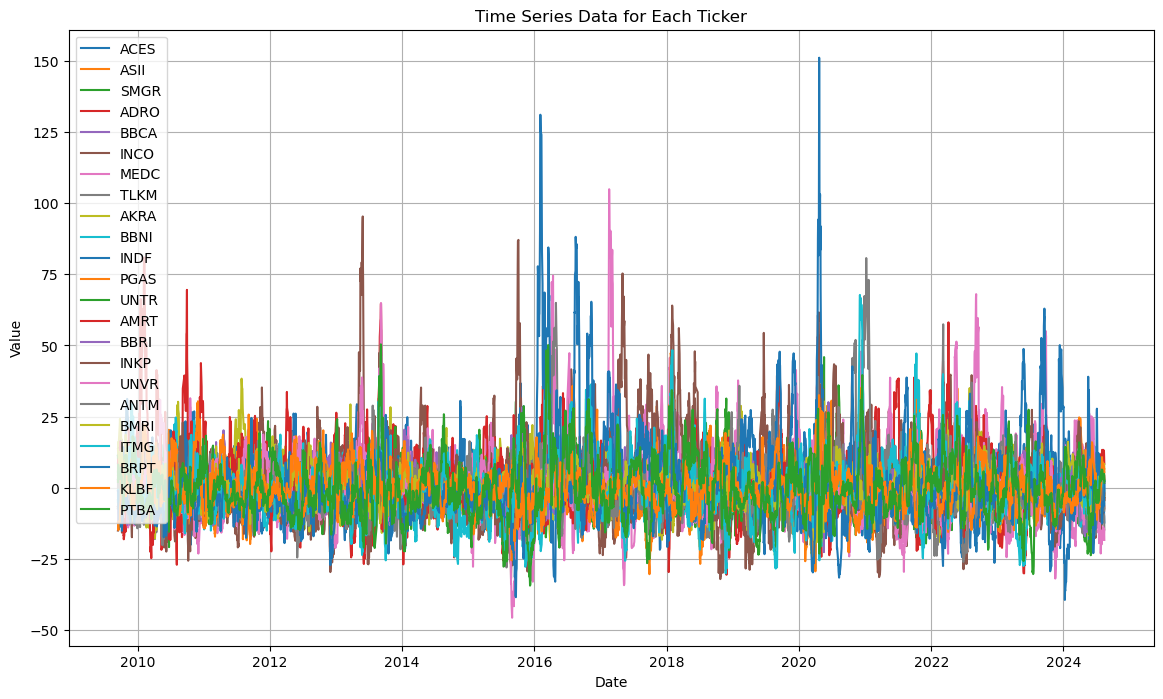

In [44]:
covs.index = pd.to_datetime(covs.index)

# Plot the time series data for each ticker
plt.figure(figsize=(14, 8))

for column in covs.columns:
    plt.plot(covs.index, covs[column], label=column)

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Time Series Data for Each Ticker')
plt.legend(loc='upper left')
plt.grid(True)

# Show the plot
plt.show()

In [45]:
cov_matrix = covs.cov()
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

idx = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

total_variance = np.sum(eigenvalues)
cumulative_variance_ratio = np.cumsum(eigenvalues) / total_variance

p = 0.30
k = np.argmax(cumulative_variance_ratio >= (1 - p )) + 1

print("Number of PCA Components", k)

pca = PCA(n_components=k)
#TODO: Check for unnormalized data??
train_norm = (covs - covs.mean()) / covs.std()
reduced_data = pca.fit_transform(train_norm)

def train_hmm(factor_returns, max_states=8):
    """
    Train HMM models with different numbers of states and select
    :param factor_returns: 
    :param max_states: 
    :return: 
    """
    best_model_aic = None
    best_aic = np.inf
    best_model_bic = None
    best_bic = np.inf

    for n_states in range(2, max_states + 1):
        model = hmm.GaussianHMM(n_components=n_states, covariance_type="diag", n_iter=1000)

        try:
            model.fit(factor_returns)
            # Calculate log likelihood
            log_likelihood = model.score(factor_returns)
            # Number of parameters:
            # Transition matrix: (n_states * (n_states - 1))
            # Emission probabilities: (n_states * factor_returns.shape[1] * 2)
            n_params = n_states * (n_states - 1) + 2 * n_states * factor_returns.shape[1]

            # Calculate AIC
            aic = -2 * log_likelihood + 2 * n_params

            # Calculate BIC
            bic = -2 * log_likelihood + n_params * np.log(factor_returns.shape[0])

            # Select the model with the best AIC
            if aic < best_aic:
                best_aic = aic
                best_model_aic = model

            # Select the model with the best BIC
            if bic < best_bic:
                best_bic = bic
                best_model_bic = model

        except Exception as e:
            print(f"Model with {n_states} states failed to converge: {e}")
            continue

    return best_model_aic, best_model_bic, best_aic, best_bic

best_model_aic, best_model_bic, best_aic, best_bic = train_hmm(reduced_data)

Number of PCA Components 8


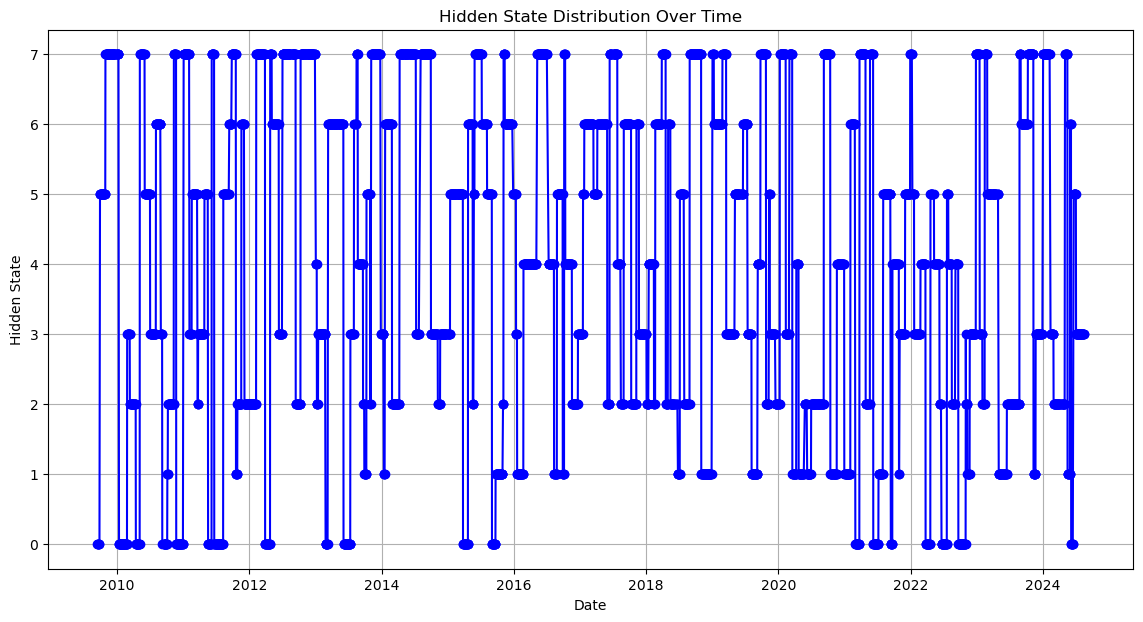

In [46]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming best_model_bic is your selected model (you can choose best_model_aic as well)
hidden_states = best_model_bic.predict(reduced_data)

# Combine hidden states with dates from the original DataFrame
states_df = pd.DataFrame({
    'Date': covs.index,  # Assuming 'covs' has a DateTime index
    'Hidden_State': hidden_states
})

# Plot the hidden state distribution over time
plt.figure(figsize=(14, 7))
plt.plot(states_df['Date'], states_df['Hidden_State'], marker='o', linestyle='-', color='blue')
plt.title('Hidden State Distribution Over Time')
plt.xlabel('Date')
plt.ylabel('Hidden State')
plt.grid(True)
plt.show()

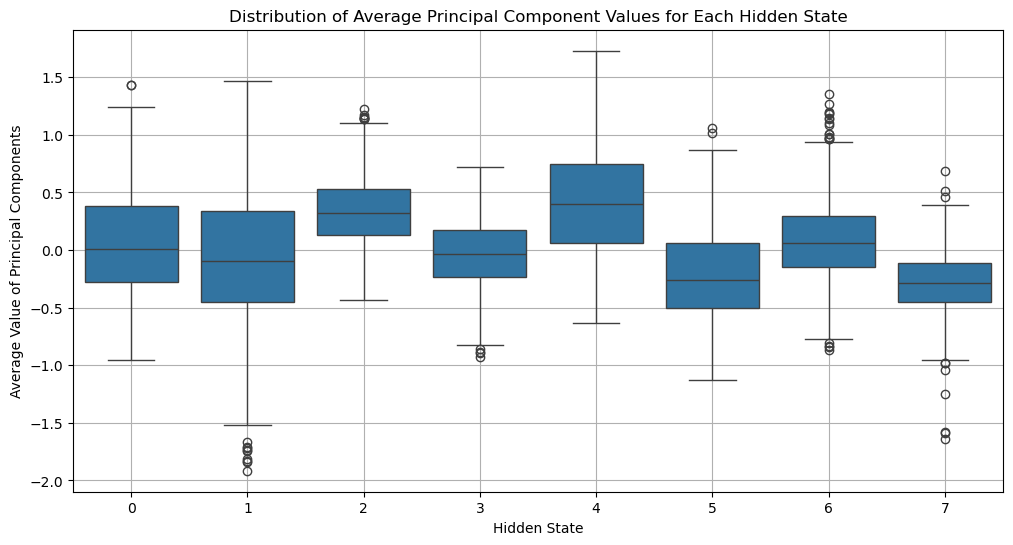

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Predict the hidden states
hidden_states = best_model_bic.predict(reduced_data)

# Calculate the average of all principal components for each observation
average_values = np.mean(reduced_data, axis=1)

# Combine hidden states with the averaged values
state_values_df = pd.DataFrame({
    'Hidden_State': hidden_states,
    'Average_Value': average_values
})

# Plot the range of average values for each hidden state using a box plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='Hidden_State', y='Average_Value', data=state_values_df)
plt.title('Distribution of Average Principal Component Values for Each Hidden State')
plt.xlabel('Hidden State')
plt.ylabel('Average Value of Principal Components')
plt.grid(True)
plt.show()

In [54]:
hidden_states = best_model_bic.predict(reduced_data)

(3624,)

In [57]:
reduced_df.index = covs.index
pd.to_datetime(reduced_df.index)
reduced_df['hidden_states'] = hidden_states

In [62]:
reduced_df.columns[:-1]

Index([0, 1, 2, 3, 4, 5, 6, 7], dtype='object')

                   0         1         2         3         4         5  \
Dates                                                                    
2009-09-14 -0.465830  2.589163 -0.771335 -0.702747  1.484605 -1.117186   
2009-09-15  0.052623  3.353134 -1.131928 -0.952523  2.065456 -1.096562   
2009-09-16  0.771314  2.154827 -0.869714 -0.786737  2.497836 -0.820415   
2009-09-17 -0.265869  2.433069 -0.320666 -0.974864  2.025086 -1.288139   
2009-09-24 -0.339812  0.618888 -0.095831 -1.177646  1.765806 -1.082376   

                   6         7  hidden_states     Total  Quintile  \
Dates                                                               
2009-09-14 -0.821611  1.102345              0  1.297404         3   
2009-09-15 -1.543206  0.664345              0  1.411338         3   
2009-09-16 -1.273804  0.616433              0  2.289741         3   
2009-09-17 -1.735929  0.509831              0  0.382519         2   
2009-09-24 -1.451791  1.427003              0 -0.335761         2  

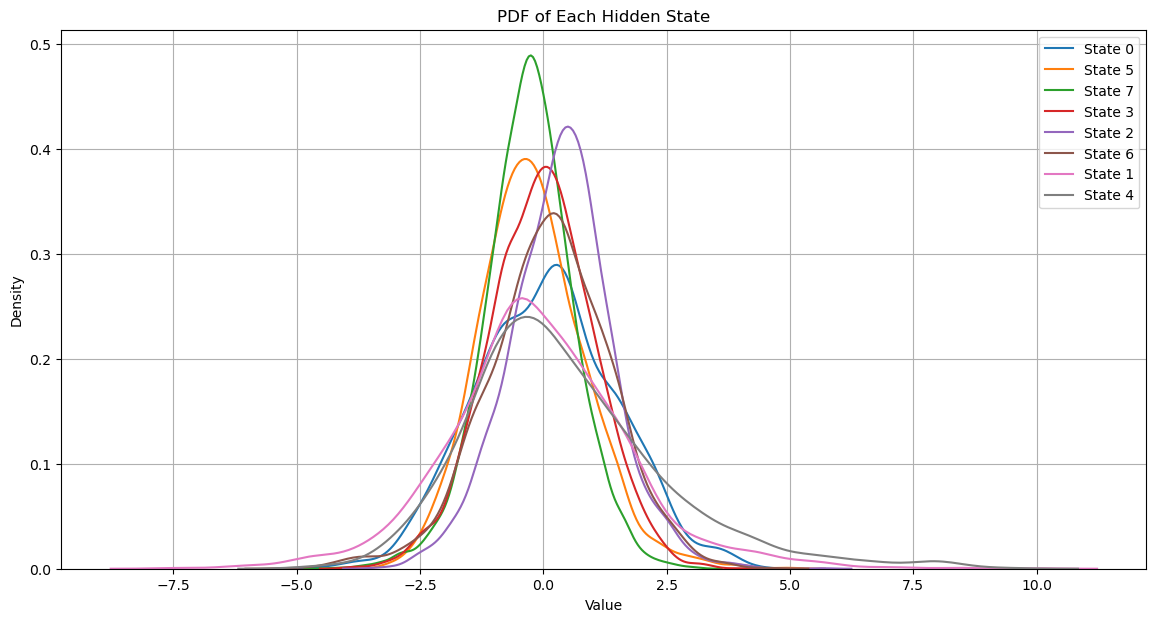

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming reduced_df contains the principal components and hidden states
df = reduced_df.copy()

# Calculate quintiles for the entire DataFrame based on the sum of principal components
df['Total'] = df.iloc[:, :-1].sum(axis=1)  # Summing across principal components, assuming last column is 'hidden_states'
df['Quintile'] = pd.qcut(df['Total'], 5, labels=False)

# Now, calculate the average of each quintile within each hidden state
quintile_averages = df.groupby(['hidden_states', 'Quintile']).mean().iloc[:, :-2]  # Exclude 'Total' and 'Quintile'

# Prepare the columns for storing quintile averages in the main DataFrame
for q in range(5):
    df[f'Quintile_{q+1}_Avg'] = df.apply(lambda row: quintile_averages.loc[
        (row['hidden_states'], q)
    ].mean(), axis=1)

# Display the updated DataFrame with new columns for quintile averages
print(df.head())

# Drop the temporary 'Total' and 'Quintile' columns used for calculation
df.drop(columns=['Total', 'Quintile'], inplace=True)

# Plot the PDFs for each hidden state, using seaborn
plt.figure(figsize=(14, 7))

for state in df['hidden_states'].unique():
    sns.kdeplot(df[df['hidden_states'] == state].iloc[:, :-6].stack(), label=f'State {state}')  # Exclude last 5 columns

plt.title('PDF of Each Hidden State')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

In [67]:
df.to_csv('./covset0/preds/hmm.csv')

OSError: Cannot save file into a non-existent directory: 'covset0/preds'

In [51]:
reduced_df = pd.DataFrame(reduced_data)

<Figure size 1200x800 with 0 Axes>

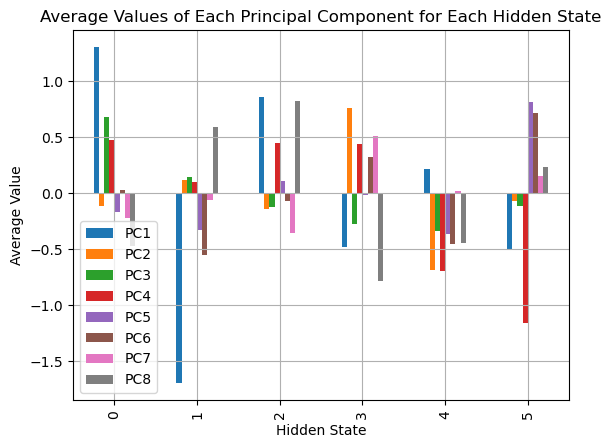

                            PC1       PC2       PC3       PC4       PC5  \
Hidden_State Quintile                                                     
0            0        -2.672350 -0.668456  1.239131  0.613239  0.018994   
             1        -0.938455 -0.828819  1.130982  0.742254 -0.714090   
             2        -0.129786 -0.428031  0.700386  0.996189  0.016769   
             3         0.799109  0.768388  0.876937  0.960522  0.435747   
             4         3.651199  0.164323  0.329929  0.199243 -0.261530   
1            0        -2.391528  0.043719  0.142097  0.198989 -0.376600   
             1        -1.024290  0.185801  0.140489 -0.031123 -0.204200   
             2        -0.297443  0.304719  0.090229 -0.004533 -0.491394   
             3         0.522951  0.140036  1.293529  0.453033 -0.692497   
2            0        -1.811199 -1.446222 -0.645553  1.436276 -0.246641   
             1        -0.933473 -0.718382 -0.024736  0.932259  0.120266   
             2        -0.

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Predict the hidden states
hidden_states = best_model_bic.predict(reduced_data)

# Create a DataFrame with the hidden states, dates, and reduced data (principal components)
states_df = pd.DataFrame(reduced_data, columns=[f'PC{i+1}' for i in range(reduced_data.shape[1])])
states_df['Hidden_State'] = hidden_states
states_df['Date'] = covs.index  # Assuming 'covs' has a DateTime index

# Calculate the average of each principal component for each hidden state
average_values = states_df.groupby('Hidden_State').mean().drop(columns=['Date'])

# Plot the average of each principal component for each hidden state
plt.figure(figsize=(12, 8))
average_values.plot(kind='bar')
plt.title('Average Values of Each Principal Component for Each Hidden State')
plt.xlabel('Hidden State')
plt.ylabel('Average Value')
plt.grid(True)
plt.show()

# Calculate averages for each quintile within each hidden state
states_df['Quintile'] = pd.qcut(states_df['PC1'], 5, labels=False)  # Using PC1 for quintile calculation, adjust as needed
quintile_averages = states_df.groupby(['Hidden_State', 'Quintile']).mean().drop(columns=['Date'])

# Display the quintile averages
print(quintile_averages)

# Create a DataFrame with dates and their corresponding hidden states
hidden_states_with_dates = states_df[['Date', 'Hidden_State']]

# Display the DataFrame
print(hidden_states_with_dates)